# Practical 1

> Tinghao(Vitus) Xie

In [117]:
import _pickle as cp
import numpy as np
from matplotlib import pyplot as plt

# Load data from disk
X, y = cp.load(open('winequality-white.pickle', 'rb'))

# Split data
N, D = X.shape
N_train = int(0.8 * N)
N_test = N - N_train

X_train = X[:N_train]
y_train = y[:N_train]
X_test = X[N_train:]
y_test = y[N_train:]

## Understanding What We're Predicting

### **Handin 1**: Make a bar chart showing the distribution of $y$ values appearing in the training set.

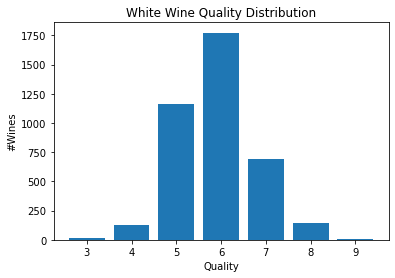

In [23]:
data = [(y_train == i).sum() for i in range(3, 10)]
plt.bar(range(3, 10), data)
plt.title('White Wine Quality Distribution')
plt.xlabel('Quality')
plt.ylabel('#Wines')
plt.show()

### **Handin 2**: Report the mean squared error, i.e., the average of the squared residuals, using this simplest of predictors on the training and test data.

In [68]:
y_train_avg = y.mean() # Average, will be used as our prediction temporarily
print("Prediction is always", y_train_avg)
print("Mean squared error on training set is", ((y_train - y_train_avg) ** 2).sum() / y_train.shape[0])
print("Mean squared error on test set is", ((y_test - y_train_avg) ** 2).sum() / y_test.shape[0])

Prediction is always 5.87790935075541
Mean squared error on training set is 0.7767779702311379
Mean squared error on test set is 0.8138507187613643


## Linear Model Using Least Squares

First standardize the training data.

In [69]:
# Get the original mean and variance
X_train_mean = X_train.mean(axis=0)
X_train_var = X_train.var(axis=0)

# Standardize the features
X_train_standard = (X_train - X_train_mean) / np.sqrt(X_train_var)
X_test_standard = (X_test - X_train_mean) / np.sqrt(X_train_var)

# Also standardize the outputs to [-1, 1] for removing the bias term
y_train_standard = (y_train - 6) / 3

We don't need to consider about the constant term in the linear model now. So The linear model's closed form solution would simply be:

$$
\hat{\textbf y}=\textbf X \textbf w=\textbf X_{train}(\textbf X_{train}^T\textbf X_{train})^{-1}\textbf X_{train}^T\textbf y\\
or\ \textbf w=(\textbf X_{train}^T\textbf X_{train})^{-1}\textbf X_{train}^T \textbf y
$$

In [70]:
# The weight matrix (shape of [11, 1])
w = np.matmul(np.matmul(np.linalg.inv(np.matmul(X_train_standard.transpose(), X_train_standard)), X_train_standard.transpose()), y_train_standard)
print(w.shape)

(11,)


### **Handin 3**: Report the mean squared error using the linear model on the training and test data.

In [71]:
# Evaluate on training set
y_eval = np.matmul(X_train_standard, w)
y_eval = y_eval * 3 + 6
print("Mean squared error on training set is", ((y_train - y_eval) ** 2).sum() / y_train.shape[0])

# Evaluate on testing set
y_eval = np.matmul(X_test_standard, w)
y_eval = y_eval * 3 + 6
print("Mean squared error on test set is", ((y_test - y_eval) ** 2).sum() / y_test.shape[0])

Mean squared error on training set is 0.578697621214545
Mean squared error on test set is 0.5784207178333369


## Learning Curves

### **Handin 4**: Report the learning curves plot. Also, explain whether you think the model is underﬁtting or not, and how much data you need before getting the optimal test error.

**Answer**:
- From the curves below, we can tell that about 80 training samples would approch the optimal test error.
- And with about 300 samples the training loss and test loss would be basically the same.
- The model is underfitting, since the bias is high (and more data won't help).

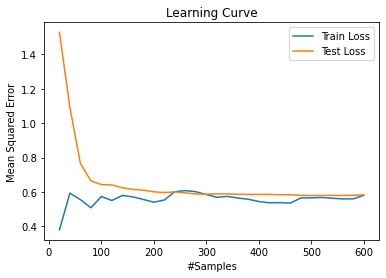

In [89]:
num_samples = 20
train_loss = []
test_loss = []

while num_samples <= 600:
    # Only use the first `num_samples` data points
    x_standard = X_train_standard[:num_samples]
    y_standard = y_train_standard[:num_samples]
    y = y_train[:num_samples]
    
    # Closed form solution to the linear model
    w = np.matmul(np.matmul(np.linalg.inv(np.matmul(x_standard.transpose(), x_standard)), x_standard.transpose()), y_standard)

    # Predict and get train loss
    y_eval = np.matmul(x_standard, w)
    y_eval = y_eval * 3 + 6
    train_loss.append(((y - y_eval) ** 2).sum() / num_samples)
    
    # Predict and get test loss
    y_eval = np.matmul(X_test_standard, w)
    y_eval = y_eval * 3 + 6
    test_loss.append(((y_test - y_eval) ** 2).sum() / y_test.shape[0])

    num_samples += 20

# Plot the learning curve
x_range = [i for i in range(601)][20::20]
plt.plot(x_range, train_loss, '-', label='Train Loss')
plt.plot(x_range, test_loss, '-', label='Test Loss')
plt.legend()
plt.title('Learning Curve')
plt.xlabel('#Samples')
plt.ylabel('Mean Squared Error')
plt.show()

## Polynomial Basis Expansion with Ridge and Lasso

In [140]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [118]:
# Load data from disk
X, y = cp.load(open('winequality-white.pickle', 'rb'))

# Split data to train & test
N, D = X.shape
N_train = int(0.8 * N)
N_test = N - N_train

X_train = X[:N_train]
y_train = y[:N_train]
X_test = X[N_train:]
y_test = y[N_train:]

# Further split train set to train & val, for selecting hyper-parameters
N_train = X_train.shape[0]
N_val = int(N_train * .2)
N_train = N_train - N_val

X_val = X_train[N_train:]
y_val = y_train[N_train:]
X_train = X_train[:N_train]
y_train = y_train[:N_train]

print("Train set size: {}\nVal set size: {}\nTest set size: {}".format(X_train.shape[0], X_val.shape[0], X_test.shape[0]))

Train set size: 3135
Val set size: 783
Test set size: 980


In [123]:
preprocess = make_pipeline(StandardScaler(), PolynomialFeatures(2))

# Ridge
alpha = 1e-2 # i.e. lambda
val_loss = []
for i in range(5):
    clf = Ridge(alpha=alpha)
    clf.fit(preprocess.fit_transform(X_train), y_train)
    alpha *= 10
    y_eval = clf.predict(preprocess.transform(X_val))
    val_loss.append(((y_val - y_eval) ** 2).sum() / y_val.shape[0])
# Choose the best alpha
alpha = 1e-2 * (10 ** np.argmin(val_loss))
print("[Ridge] alpha =", alpha)
# Train with full training set
X_full_train = np.concatenate((X_train, X_val))
y_full_train = np.concatenate((y_train, y_val))
clf = Ridge(alpha=alpha)
clf.fit(preprocess.fit_transform(X_full_train), y_full_train)
# Evaluate
y_eval = clf.predict(preprocess.transform(X_full_train))
print("[Ridge] Mean squared error on train set is", ((y_full_train - y_eval) ** 2).sum() / y_full_train.shape[0])
y_eval = clf.predict(preprocess.transform(X_test))
print("[Ridge] Mean squared error on test set is", ((y_test - y_eval) ** 2).sum() / y_test.shape[0])

# Lasso
alpha = 1e-2 # i.e. lambda
val_loss = []
for i in range(5):
    clf = Lasso(alpha=alpha)
    clf.fit(preprocess.fit_transform(X_train), y_train)
    alpha *= 10
    y_eval = clf.predict(preprocess.transform(X_val))
    val_loss.append(((y_val - y_eval) ** 2).sum() / y_val.shape[0])
# Choose the best alpha
alpha = 1e-2 * (10 ** np.argmin(val_loss))
print("[Lasso] alpha =", alpha)
# Train with full training set
X_full_train = np.concatenate((X_train, X_val))
y_full_train = np.concatenate((y_train, y_val))
clf = Lasso(alpha=alpha)
clf.fit(preprocess.fit_transform(X_full_train), y_full_train)
# Evaluate
y_eval = clf.predict(preprocess.transform(X_full_train))
print("[Lasso] Mean squared error on train set is", ((y_full_train - y_eval) ** 2).sum() / y_full_train.shape[0])
y_eval = clf.predict(preprocess.transform(X_test))
print("[Lasso] Mean squared error on test set is", ((y_test - y_eval) ** 2).sum() / y_test.shape[0])

[Ridge] alpha = 10.0
[Ridge] Mean squared error on train set is 0.4954631041385635
[Ridge] Mean squared error on test set is 0.51166774565843
[Lasso] alpha = 0.01
[Lasso] Mean squared error on train set is 0.5138328252782884
[Lasso] Mean squared error on test set is 0.5185523039167391


# Larger Degrees

Use $k$-fold to determine hyperparameters using a higher degree basis expansion.

In [141]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from tqdm import tqdm

In [138]:
# Load data from disk
X, y = cp.load(open('winequality-white.pickle', 'rb'))

# Split data to train & test
N, D = X.shape
N_train = int(0.8 * N)
N_test = N - N_train

X_full_train = X[:N_train]
y_full_train = y[:N_train]
X_test = X[N_train:]
y_test = y[N_train:]

print("Train set size: {}\nTest set size: {}".format(X_full_train.shape[0], X_test.shape[0]))

Train set size: 3918
Test set size: 980


### Ridge Regression with 5-fold

The result seems somehow worse than 2-degree basis expansion (and without $k$-fold).

In [197]:
poly_degree = 3
n_splits = 5
alpha_init = 1e-5
iter_alpha = 10
factor = 10

preprocess = make_pipeline(StandardScaler(), PolynomialFeatures(poly_degree))
kf = KFold(n_splits=n_splits)

# Ridge
best_loss = np.Infinity
best_alpha = alpha_init
for train_index, test_index in kf.split(X_full_train):
    X_train = X_full_train[train_index]
    y_train = y_full_train[train_index]
    X_val = X_full_train[test_index]
    y_val = y_full_train[test_index]
    
    alpha = alpha_init # i.e. lambda
    val_loss = []
    for i in tqdm(range(iter_alpha)):
        clf = Ridge(alpha=alpha)
        clf.fit(preprocess.fit_transform(X_train), y_train)
        alpha *= factor
        y_eval = clf.predict(preprocess.transform(X_val))
        val_loss.append(((y_val - y_eval) ** 2).sum() / y_val.shape[0])
    # Update globally best loss & alpha
    if best_loss > np.min(val_loss):
        best_loss = np.min(val_loss)
        best_alpha = alpha_init * (factor ** np.argmin(val_loss))
print("[Ridge] Best alpha =", best_alpha)
# Train with full training set
clf = Ridge(alpha=best_alpha)
clf.fit(preprocess.fit_transform(X_full_train), y_full_train)
# Evaluate
print("[Ridge] Previously, best mean squared error on val set is", best_loss)
y_eval = clf.predict(preprocess.transform(X_full_train))
print("[Ridge] Mean squared error on train set is", ((y_full_train - y_eval) ** 2).sum() / y_full_train.shape[0])
y_eval = clf.predict(preprocess.transform(X_test))
print("[Ridge] Mean squared error on test set is", ((y_test - y_eval) ** 2).sum() / y_test.shape[0])

100%|██████████| 10/10 [00:00<00:00, 45.28it/s]

[Ridge] Best alpha = 1000.0000000000001
[Ridge] Previously, best mean squared error on val set is 0.5262248469891102
[Ridge] Mean squared error on train set is 0.45629981715481616
[Ridge] Mean squared error on test set is 0.5421485096673404


### Lasso Regression with 5-fold

The optimization seems difficult to converge for small $\lambda$. But the best error (0.5072) seems a little better than 2-degree basis expansion.

In [191]:
poly_degree = 3
n_splits = 5
alpha_init = 1e-4
iter_alpha = 5
factor = 10

preprocess = make_pipeline(StandardScaler(), PolynomialFeatures(poly_degree))
kf = KFold(n_splits=n_splits)

# Lasso
best_loss = np.Infinity
best_alpha = alpha_init
for train_index, test_index in kf.split(X_full_train):
    X_train = X_full_train[train_index]
    y_train = y_full_train[train_index]
    X_val = X_full_train[test_index]
    y_val = y_full_train[test_index]

    alpha = alpha_init # i.e. lambda
    val_loss = []
    for i in tqdm(range(iter_alpha)):
        if i < 2: continue
        clf = Lasso(alpha=alpha, max_iter=5000)
        clf.fit(preprocess.fit_transform(X_train), y_train)
        alpha *= 10
        y_eval = clf.predict(preprocess.transform(X_val))
        val_loss.append(((y_val - y_eval) ** 2).sum() / y_val.shape[0])
    # Update globally best loss & alpha
    if best_loss > np.min(val_loss):
        best_loss = np.min(val_loss)
        best_alpha = alpha_init * (10 ** np.argmin(val_loss))
print("[Lasso] Best alpha =", best_alpha)
# Train with full training set
clf = Lasso(alpha=best_alpha, max_iter=5000)
clf.fit(preprocess.fit_transform(X_full_train), y_full_train)
# Evaluate
print("[Lasso] Previously, best mean squared error on val set is", best_loss)
y_eval = clf.predict(preprocess.transform(X_full_train))
print("[Lasso] Mean squared error on train set is", ((y_full_train - y_eval) ** 2).sum() / y_full_train.shape[0])
y_eval = clf.predict(preprocess.transform(X_test))
print("[Lasso] Mean squared error on test set is", ((y_test - y_eval) ** 2).sum() / y_test.shape[0])


  0%|          | 0/5 [00:00<?, ?it/s]/Users/vtu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 583.1760394764294, tolerance: 0.24286818761965562
  model = cd_fast.enet_coordinate_descent(
 60%|██████    | 3/5 [00:04<00:02,  1.49s/it]/Users/vtu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 306.33159506265724, tolerance: 0.24286818761965562
  model = cd_fast.enet_coordinate_descent(
  0%|          | 0/5 [00:00<?, ?it/s]/Users/vtu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 315.9951266439087, tolerance: 0.24814170389278

[Lasso] Best alpha = 0.01
[Lasso] Previously, best mean squared error on val set is 0.5095863010894448
[Lasso] Mean squared error on train set is 0.46857682318417443
[Lasso] Mean squared error on test set is 0.5071786105362784
